In [ ]:
# !pip install python-Levenshtein -q

In [9]:
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)

In [51]:
csv_file_path = "./project_3.csv"
df = pd.read_csv(csv_file_path)
output_df = df.copy()

# Simple Data Exploration over the whole dataset

In [11]:
df_columns = [column for column in df.columns]
print(df_columns)

['prefix', 'lastname', 'firstname', 'firstname_mother', 'firstname_father', 'description', 'inquiry', 'dob', 'account_creation_date', 'last_transaction_date', 'account_resiliation_date', 'first_contact_date', 'last_contact_date', 'latlon_home', 'latlon_work', 'x35_bank_branch', 'email_work', 'email_personnal', 'email_sso', 'email_vpn', 'xml_authent_token', 'profile_json', 'cia_info_json', 'salary', 'first_salary', 'taxable_income', 'transaction_amount', 'credit_card_score', 'credit_card_number', 'weight', 'height', 'shoe_size', 'bank_balance', 'address', 'city', 'zip', 'country', 'customer_code', 'customer_uid', 'android_platform', 'user_agent', 'blog_url', 'customer_segment_code', 'customer_market_code', 'customer_fico_score']


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prefix                    10000 non-null  object 
 1   lastname                  10000 non-null  object 
 2   firstname                 10000 non-null  object 
 3   firstname_mother          10000 non-null  object 
 4   firstname_father          9915 non-null   object 
 5   description               10000 non-null  object 
 6   inquiry                   10000 non-null  object 
 7   dob                       10000 non-null  object 
 8   account_creation_date     10000 non-null  object 
 9   last_transaction_date     10000 non-null  object 
 10  account_resiliation_date  10000 non-null  object 
 11  first_contact_date        10000 non-null  object 
 12  last_contact_date         10000 non-null  object 
 13  latlon_home               10000 non-null  object 
 14  latlon_

In [13]:
print(df.describe())

             salary  first_salary  taxable_income  transaction_amount  credit_card_score  credit_card_number        weight        height     shoe_size  bank_balance           zip  customer_code  customer_segment_code  customer_market_code  customer_fico_score
count  1.000000e+04  1.000000e+04    10000.000000        10000.000000       10000.000000        1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000         9464.0            8965.000000           8845.000000          8582.000000
mean   3.410324e+06 -3.562806e+06    11734.681400          891.612898          47.896294        4.990246e+15     66.658873    178.285417     41.985855   1497.924500  50506.264100           27.0              14.855438         266412.692369            18.704847
std    1.817860e+07  1.960390e+07     8062.124853          521.556578          18.523971        2.872614e+15     15.629118     37.951751      1.947280    578.267814  28798.239246            0.0               5.740120    

In [14]:
missing_values_count = df.isna().sum()
missing_values_count_non_zero = missing_values_count[missing_values_count > 0]
print(f"Number of missing values per column:\n"
      f"{missing_values_count_non_zero}")

Number of missing values per column:
firstname_father           85
customer_code             536
customer_segment_code    1035
customer_market_code     1155
customer_fico_score      1418
dtype: int64


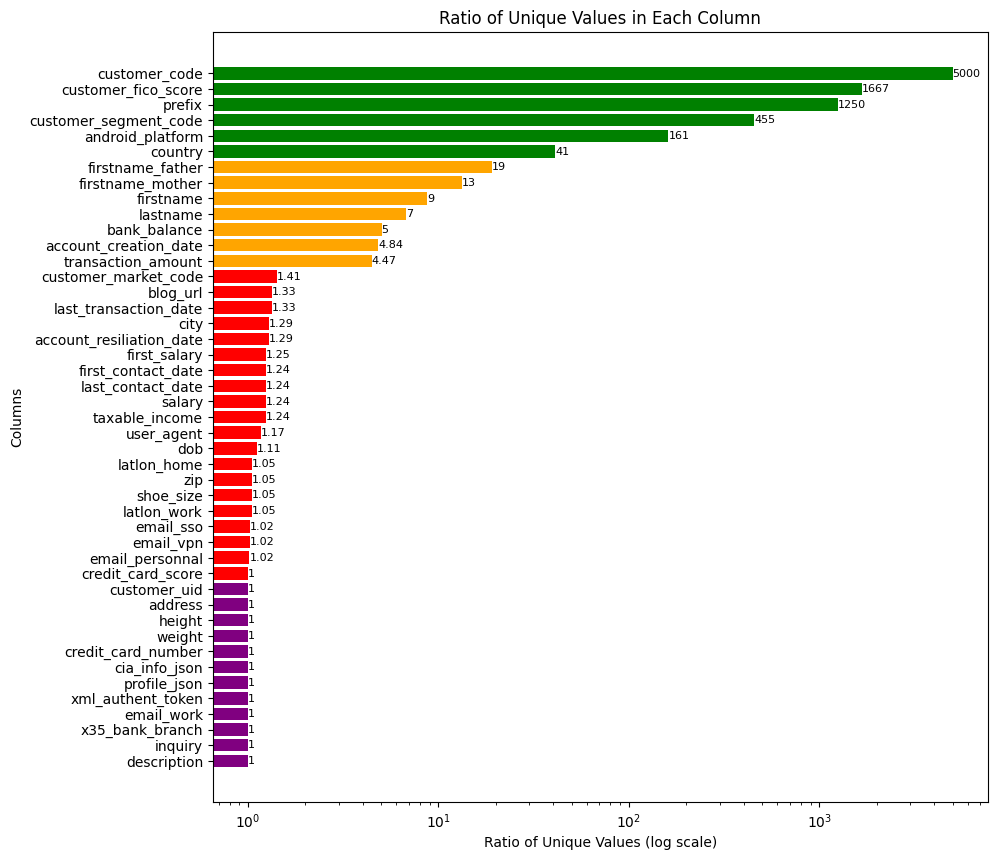

In [15]:
unique_count = []
for column in df.columns:
    ratio_unique_value = len(df[column]) / len(df[column].unique())
    unique_count.append((column, ratio_unique_value))

unique_count.sort(key=lambda x: x[1])

thresholds = [1, 2, 20]  
colors = ['purple', 'red', 'orange', 'green']

color_map = np.digitize([ratio for _, ratio in unique_count], thresholds, right=True)

columns, ratios = zip(*unique_count)
plt.figure(figsize=(10, 10))
bar_plot = plt.barh(columns, ratios, color=[colors[idx] for idx in color_map])
plt.xscale('log')
plt.xlabel('Ratio of Unique Values (log scale)')
plt.ylabel('Columns')
plt.title('Ratio of Unique Values in Each Column')

for i, ratio in enumerate(ratios):
    if ratio > 5 or int(ratio * 100) % 10 == 0:
        text = f'{ratio:.0f}'
    else:
        text = f'{ratio:.2f}'
    plt.text(ratio, i, text, ha='left', va='center', color='black', fontsize=8)

plt.show()

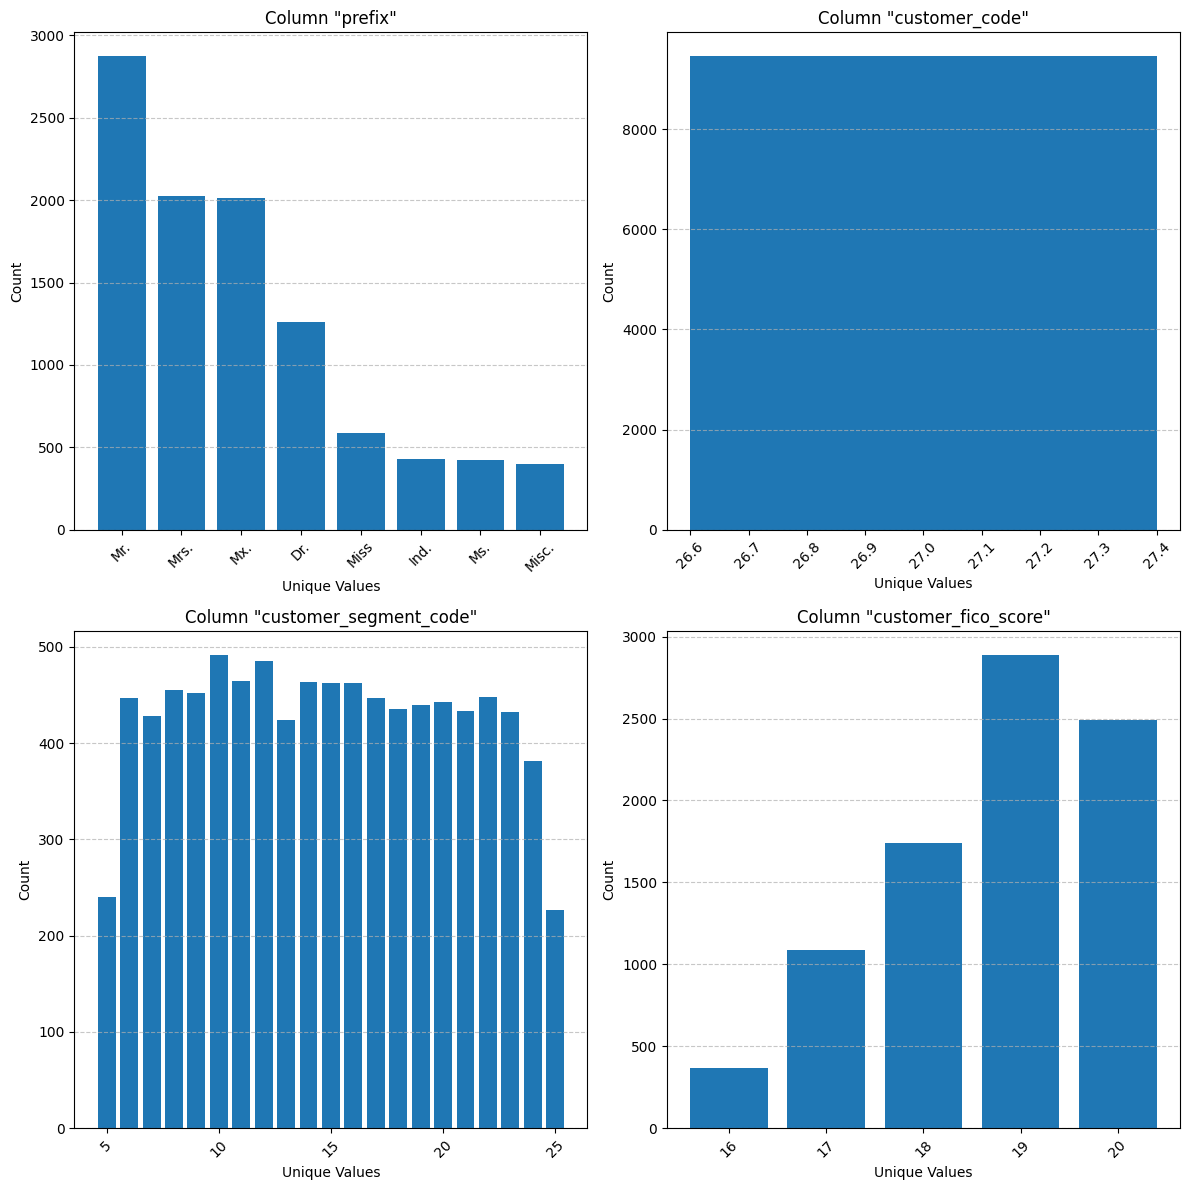

In [16]:
max_unique_val = 30

valid_columns_count = sum(1 for column_name in df.columns if len(df[column_name].value_counts().index) < 20)

num_rows = (valid_columns_count + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

if num_rows == 1 and num_cols == 1:
    axs = [axs]

subplot_index = 0
for column_name in df.columns:
    unique_values_distribution = df[column_name].value_counts()
    if len(unique_values_distribution.index) < max_unique_val:
        row_index = subplot_index // num_cols
        col_index = subplot_index % num_cols

        axs[row_index, col_index].bar(unique_values_distribution.index, unique_values_distribution.values)
        axs[row_index, col_index].set_title('Column "{}"'.format(column_name))
        axs[row_index, col_index].set_xlabel('Unique Values')
        axs[row_index, col_index].set_ylabel('Count')
        axs[row_index, col_index].tick_params(axis='x', rotation=45)
        axs[row_index, col_index].grid(axis='y', linestyle='--', alpha=0.7)
        
        subplot_index += 1

plt.tight_layout()
plt.show()

# String Cleaning 3 / 23

## Normal 3 / 18

In [85]:
class name_str_cleaning:
    def __init__(self, df, interested_column, pattern=re.compile(r'[^a-zA-Z]')):
        self.df = df
        self.interested_column = interested_column
        self.missing_values_count = df[interested_column].isna().sum()
        self.pattern = pattern
        self.inconsistencies = []
        self.inconsistency_count = 0
        self.correct_lastnames = None
        self.inferred_lastnames = []
        self.names_without_match = []

    def find_missing_values(self):
        print(f'There are {self.missing_values_count} missing value(s) in the column {self.interested_column}')
        
    def identify_inconsistencies(self, show = True):     
        for index, row in self.df.iterrows():
            name = row[self.interested_column]
            if re.search(self.pattern, name):
                self.inconsistencies.append((index, name))
                self.inconsistency_count += 1
        self.correct_lastnames = self.df[~self.df.index.isin([i[0] for i in self.inconsistencies])][self.interested_column].tolist()
        
        if show:
            print("Summary of inconsistencies:")
            for count, inconsistency in self.inconsistencies:
                print(f"Row {count}: {inconsistency}")
            print(f"Number of inconsistent {self.interested_column}: {self.inconsistency_count}")
        else:
            print(f'identify_inconsistencies executed without exception')
    
    def infer_correct_lastname(self, show = True):
        for index, row in self.df.iterrows():
            name = row[self.interested_column]
            if index in [i[0] for i in self.inconsistencies]:
                length = len(re.sub(self.pattern, '', name)) + 1
                filtered_names = [name for name in self.correct_lastnames if len(name) == length ]
                closest_match, score = process.extractOne(name, filtered_names)
                if re.search(self.pattern, closest_match):
                    self.names_without_match.append(name)
                else:   
                    self.inferred_lastnames.append((index, name, closest_match, re.search(self.pattern, closest_match), score))
    
        if show:
            for index, incorrect, inferred, invalid, score in self.inferred_lastnames:
                print(f"Row {index}: {incorrect} -> {inferred} (Similarity Score: {score})")  
        print(f"{len(self.inferred_lastnames)} names from {self.interested_column} have been inferred")
        if self.names_without_match:
            print(f"Names without a match for manual inference:\n"
                  f"{self.names_without_match}")
    
    def save(self, output_df):
        for index, _, inferred, _, _ in self.inferred_lastnames:
            output_df.at[index, self.interested_column] = inferred
        df_comparison = pd.concat([self.df[self.interested_column], output_df[self.interested_column]], axis=1)
        df_comparison.columns = ['Original', 'Cleaned']
        
        print("Difference between Original and Cleaned DataFrames:")
        print(df_comparison)


### Unique value 3 / 7

#### lastname ✅  
typing errors (Ba+rett, Ev$ns…) + incomplete> remove special characters.

In [86]:
interested_column = 'lastname'
lastname_clean_obj = name_str_cleaning(df, interested_column)

In [87]:
lastname_clean_obj.find_missing_values()

There are 0 missing value(s) in the column lastname


In [88]:
lastname_clean_obj.identify_inconsistencies(show = False)

identify_inconsistencies executed without exception


In [89]:
lastname_clean_obj.infer_correct_lastname(show = False)

507 names from lastname have been inferred


In [90]:
lastname_clean_obj.save(output_df)

Difference between Original and Cleaned DataFrames:
       Original    Cleaned
0      Figueroa   Figueroa
1         Smith      Smith
2     Nicholson  Nicholson
3        Harvey     Harvey
4       Sanchez    Sanchez
...         ...        ...
9995    Coleman    Coleman
9996      Dixon      Dixon
9997    V(zquez    Vazquez
9998     Greene     Greene
9999       Wolf       Wolf

[10000 rows x 2 columns]


#### firstname ✅
typing errors with spaces (L   sa, Ell   n…) > remove spaces and add letter (names library).

In [91]:
interested_column = 'firstname'
lastname_clean_obj = name_str_cleaning(df, interested_column)

In [92]:
lastname_clean_obj.find_missing_values()

There are 0 missing value(s) in the column firstname


In [93]:
lastname_clean_obj.identify_inconsistencies()

Summary of inconsistencies:
Row 11: Elizabet   
Row 16:    ara
Row 26:    ean
Row 27: Jor   e
Row 29:   asey
Row 33: Laur    
Row 39: A  y
Row 84: R    becca
Row 93: Krysta  
Row 105: Er          c
Row 106: K    ren
Row 166: Ren      e
Row 184: Danie   
Row 196: Don        a
Row 225: Cy       thia
Row 262: C          lleen
Row 265: Lanc       
Row 271: T       mothy
Row 277: Ant          ony
Row 295: Zach ry
Row 311:      asmine
Row 330: Caro 
Row 336: Gi  a
Row 356: Dani    lle
Row 364: Meg     n
Row 394: Rod    ey
Row 404: Elle       
Row 406:      regory
Row 411: J    mes
Row 418: To          d
Row 443: D   rrick
Row 460:       harles
Row 462: Grego          y
Row 495: Dav  d
Row 514:       arie
Row 535: Bre          da
Row 550: M      ry
Row 592: D   niel
Row 619: Car    ie
Row 647: K         istie
Row 661: S   even
Row 666: Meliss      
Row 671: Hanna 
Row 676:   ustin
Row 683: Joh      
Row 698: M lissa
Row 737: M rilyn
Row 778: Susa    
Row 782:     oe
Row 795: Lu    s
Row 798: 

In [94]:
lastname_clean_obj.infer_correct_lastname()

Row 11: Elizabet    -> Elizabeth (Similarity Score: 94)
Row 16:    ara -> Sara (Similarity Score: 86)
Row 26:    ean -> Jean (Similarity Score: 86)
Row 27: Jor   e -> Jorge (Similarity Score: 67)
Row 29:   asey -> Casey (Similarity Score: 89)
Row 33: Laur     -> Laura (Similarity Score: 89)
Row 39: A  y -> Amy (Similarity Score: 64)
Row 84: R    becca -> Rebecca (Similarity Score: 71)
Row 93: Krysta   -> Krystal (Similarity Score: 92)
Row 105: Er          c -> Eric (Similarity Score: 45)
Row 106: K    ren -> Karen (Similarity Score: 68)
Row 166: Ren      e -> Derek (Similarity Score: 57)
Row 184: Danie    -> Daniel (Similarity Score: 91)
Row 196: Don        a -> Jason (Similarity Score: 57)
Row 225: Cy       thia -> Cynthia (Similarity Score: 74)
Row 262: C          lleen -> Colleen (Similarity Score: 74)
Row 265: Lanc        -> Lance (Similarity Score: 89)
Row 271: T       mothy -> Timothy (Similarity Score: 71)
Row 277: Ant          ony -> Anthony (Similarity Score: 74)
Row 295: Zach

In [95]:
lastname_clean_obj.save(output_df)

Difference between Original and Cleaned DataFrames:
             Original      Cleaned
0             Michael      Michael
1              Donald       Donald
2             Nichole      Nichole
3               Sarah        Sarah
4         Christopher  Christopher
...               ...          ...
9995          Michael      Michael
9996        Elizabeth    Elizabeth
9997             Jose         Jose
9998  Ron          ld       Ronald
9999           Denise       Denise

[10000 rows x 2 columns]


#### firstname_mother ✅  
 typing errors (Juâ€‹ie, Laâ€‹ra…)

In [96]:
interested_column = 'firstname_mother'
lastname_clean_obj = name_str_cleaning(df, interested_column)

In [97]:
lastname_clean_obj.find_missing_values()

There are 0 missing value(s) in the column firstname_mother


In [98]:
lastname_clean_obj.identify_inconsistencies()

Summary of inconsistencies:
Row 37: ​endy
Row 64: ​ariah
Row 99: Meg​n
Row 172: As​ley
Row 234: ​lexa
Row 237: Vick​e
Row 294: Jo​ce
Row 317: Eri​a
Row 321: T​mmy
Row 324: ​eanna
Row 329: ​isa
Row 348: Cyn​hia
Row 392: Mira​da
Row 407: ​hirley
Row 495: ​manda
Row 510: C​lleen
Row 526: Kell​
Row 610: Eliza​eth
Row 627: ​tephanie
Row 629: Jessic​
Row 681: Br​dget
Row 688: Ja​queline
Row 692: Mo​ica
Row 739: Lis​
Row 745: Kathr​n
Row 753: ​ary
Row 776: Tiffan​
Row 780: Pa​ricia
Row 799: Amand​
Row 800: Elizabe​h
Row 824: Kar​na
Row 831: Andre​
Row 837: Bria​na
Row 867: ​abrielle
Row 871: M​randa
Row 880: ​elissa
Row 884: ​ori
Row 892: ​aren
Row 918: Kat​e
Row 920: ​rica
Row 940: M​ry
Row 953: V​ronica
Row 993: Mack​nzie
Row 1009: ​ina
Row 1034: ​imberly
Row 1060: ​athryn
Row 1077: ​mily
Row 1085: Cat​erine
Row 1106: K​m
Row 1118: K​tie
Row 1131: Br​nda
Row 1152: Ho​ly
Row 1158: J​ne
Row 1191: Chri​tina
Row 1228: Co​nie
Row 1295: H​lly
Row 1325: Aman​a
Row 1326: Da​a
Row 1334: Sam​ntha
Row

In [99]:
lastname_clean_obj.infer_correct_lastname()

Row 37: ​endy -> Wendy (Similarity Score: 89)
Row 64: ​ariah -> Mariah (Similarity Score: 91)
Row 99: Meg​n -> Megan (Similarity Score: 80)
Row 172: As​ley -> Ashley (Similarity Score: 83)
Row 234: ​lexa -> Alexa (Similarity Score: 89)
Row 237: Vick​e -> Vickie (Similarity Score: 83)
Row 294: Jo​ce -> Joyce (Similarity Score: 80)
Row 317: Eri​a -> Erika (Similarity Score: 80)
Row 321: T​mmy -> Tammy (Similarity Score: 80)
Row 324: ​eanna -> Deanna (Similarity Score: 91)
Row 329: ​isa -> Lisa (Similarity Score: 86)
Row 348: Cyn​hia -> Cynthia (Similarity Score: 86)
Row 392: Mira​da -> Miranda (Similarity Score: 86)
Row 407: ​hirley -> Shirley (Similarity Score: 92)
Row 495: ​manda -> Amanda (Similarity Score: 91)
Row 510: C​lleen -> Colleen (Similarity Score: 86)
Row 526: Kell​ -> Kelly (Similarity Score: 89)
Row 610: Eliza​eth -> Elizabeth (Similarity Score: 89)
Row 627: ​tephanie -> Stephanie (Similarity Score: 94)
Row 629: Jessic​ -> Jessica (Similarity Score: 92)
Row 681: Br​dget ->

In [100]:
lastname_clean_obj.save(output_df)

Difference between Original and Cleaned DataFrames:
       Original    Cleaned
0         Carol      Carol
1         Molly      Molly
2        Janice     Janice
3       Rebecca    Rebecca
4       Colleen    Colleen
...         ...        ...
9995   Kimberly   Kimberly
9996      ​mber      Amber
9997      Terry      Terry
9998   Kimberly   Kimberly
9999  Stephanie  Stephanie

[10000 rows x 2 columns]


#### firstname_father ❌
 Incomplete words (Jcob, onald…) + 92 missing values.

In [118]:
import nltk
# nltk.download('names')


def identify_inconsistencies(df, interested_column):
    inconsistency_count = 0
    inconsistencies = []
    name_list = set(nltk.corpus.names.words())
    name_list.append('Colton','Malik','Dakota',)
    
    for index, row in df.iterrows():
        name = row[interested_column]
        if isinstance(name, str): 
            if name not in name_list:
                inconsistencies.append((index, name))
                inconsistency_count += 1

    print("Summary of inconsistencies:")
    for count, inconsistency in inconsistencies:
        print(f"Row {count}: {inconsistency}")
    print(f"Number of inconsistent {interested_column}: {inconsistency_count}")
    
    names_without_match = []
    inferred_lastnames = []
    for index, row in df.iterrows():
        name = row[interested_column]
        if index in [i[0] for i in inconsistencies]:
            length = len(name) + 1
            filtered_names = [name for name in name_list if len(name) >= length ]
            closest_match, score = process.extractOne(name, filtered_names)
            if score <= 80:
                names_without_match.append(name)
            else:
                inferred_lastnames.append((index, name, closest_match, score))
    
    for index, incorrect, inferred, score in inferred_lastnames:
        print(f"Row {index}: {incorrect} -> {inferred} (Similarity Score: {score})")  
    print(f"{len(inferred_lastnames)} names from {interested_column} have been inferred")
    if names_without_match:
        print(f"Names without a match for manual inference:\n"
              f"{names_without_match}")

interested_column = 'firstname_father'
identify_inconsistencies(df,interested_column)
print(df[interested_column].iloc[9976])

Summary of inconsistencies:
Row 4: T
Row 60: Anthon
Row 78: Ke
Row 206: Jonatha
Row 224: A
Row 226: M
Row 263: Cha
Row 268: Jam
Row 283: Br
Row 284: Sc
Row 303: Rober
Row 320: Ro
Row 321: E
Row 325: Lu
Row 332: R
Row 394: Cristian
Row 422: L
Row 466: Bra
Row 472: Cristian
Row 483: Domini
Row 492: C
Row 494: W
Row 513: Ga
Row 517: Larr
Row 522: Ri
Row 600: C
Row 613: Ja
Row 621: Core
Row 640: Brando
Row 676: Joh
Row 678: J
Row 714: M
Row 793: Benjam
Row 839: A
Row 864: And
Row 871: J
Row 889: Lar
Row 919: J
Row 975: M
Row 998: A
Row 1002: J
Row 1052: Mi
Row 1063: Bra
Row 1073: M
Row 1083: Eri
Row 1118: Ad
Row 1126: Stev
Row 1128: R
Row 1160: Jame
Row 1181: Bry
Row 1182: Ad
Row 1184: Sea
Row 1242: E
Row 1273: Michae
Row 1286: Co
Row 1296: J
Row 1322: Colton
Row 1334: C
Row 1341: Da
Row 1362: Jac
Row 1376: Cli
Row 1390: Dev
Row 1400: C
Row 1420: Alexan
Row 1424: Ja
Row 1427: Ke
Row 1430: Dougla
Row 1437: C
Row 1444: B
Row 1503: Jam
Row 1528: Co
Row 1531: J
Row 1666: Tra
Row 1673: Jonatha


#### description ❌  
?

#### inquiry ❌  
?

#### address ❌  
?

### Categorical 0 / 7

#### prefix ❌  
the prefix are not always well suited to the user.


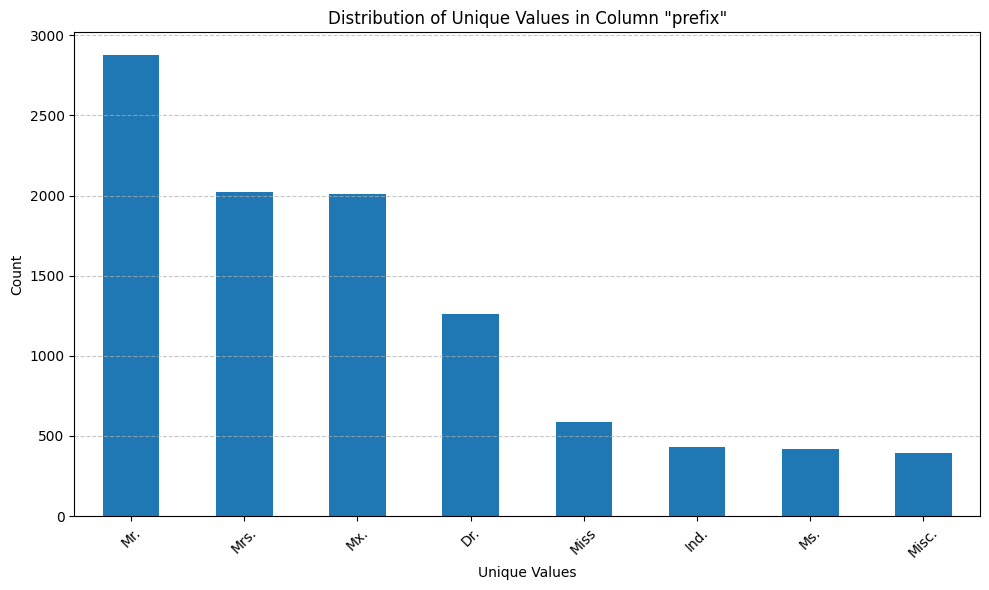

8


In [72]:
column_name = 'prefix'

unique_values_distribution = df[column_name].value_counts()

# Plot the distribution of unique values
plt.figure(figsize=(10, 6))
unique_values_distribution.plot(kind='bar')
plt.title('Distribution of Unique Values in Column "{}"'.format(column_name))
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(len(unique_values_distribution.index))

#### city ❌
?

#### country ❌  
?  
(some names are to long like “British Indian Ocean Territory (Chagos Archipelago)”, “holy see (vatican city)”, “Slovakia (Slovak Republic)”)

#### android_platform ❌  
maybe android is repeated ? (it ranges from 1 to 9 and ?)

#### user_agent ❌  
some feld have “PWNED” added randomly

#### customer_segment_code ❌  
992 missing values

#### customer_market_code ❌  
 1141 missing values and nonsense.

### Email 0 / 4

#### email_personnal ❌  
some unexpected characters ex:(hollybailey@example..org).

#### email_sso ❌  
unexpected characters ex:(paulthornton@example.Œ≥rg or craigrobe‚Ä¢ts@example.com).

#### email_vpn ❌  
unexpected characters at the end of the email adresse (​​douglasjohn@yahoo.comhg).

#### email_work ❌  
some unexpected characters ex:(jason72@!dwards-butler.info)

### Hardest - 0 / 5

#### blog_url ❌ url  
?

#### customer_uid ❌hexadecimal  
There doesn't seem to be any inherent issue with this string as a UID. However, depending on the context in which it's used, there are a few considerations:  
Uniqueness: UUIDs are typically used to uniquely identify entities. Ensure that this UUID is generated using a method that guarantees uniqueness within the intended scope (e.g., globally unique for UUIDv4).  
length: UUIDs are usually 128 bits or 32 hexadecimal characters long (excluding hyphens if present). This one seems to be of the correct length.  
Representation: Make sure the UUID is properly represented and stored in whatever system or database it's used in. For example, it might be stored as a string or a binary value depending on the requirements.  

#### xml_authent_token ❌ xml code  
?

#### profile_json ❌ json code  
?

#### cia_info_json ❌ json code  
?

# Date 0 / 6

#### dob ❌  
variation in date structure (10/7/2003 or 1987-03-58) > choose one + Customer that have more than 100 yo.

#### account_creation_date ❌  
 variation in date structure (9/21/2000 or 1999-02-29) > choose 1.

#### last_transaction_date ❌  
 hours sometimes added at the end (1/1/1970 0:00) + older than creation date ?

#### account_resiliation_date ❌  
?  
resiliation_date before creation_date ?

#### first_contact_date ❌  
inverted value between first_contact_date and last_contact_date ex: ( 02/10/1998 in first_contact_date and 12/08/1993 in last_contact_date)  

#### last_contact_date ❌  
**09**/**16**/1971 instead of **16**/**09**/1971. 

# Number 0 / 16

## Float 0 / 5

### Coordinate 0 / 3

#### latlon_home ❌  
(Decimal('-29.146587'), Decimal('-69.661657')) instead of -29.146587 latitude and -69.661657 longitude  
default value at (90, 0)  
float:  
lat -90 to 90  
long -180 to 180  

#### latlon_work ❌  
same as latlon_home except for the default coordinate being at (-27.26765, 79.60243)  
float:  
lat -90 to 90  
long -180 to 180  

#### x35_bank_branch ❌  
coordonate out of range ex: ((Decimal('99.108555'), Decimal('-30.3705825'))  
float:  
lat -90 to 90  
long -180 to 180  

## Other 0 / 2

#### credit_card_score ❌  
?

#### shoe_size ❌  
values are too precise like 41,3812748610831 and needs to be rounded to 41,5 in that case. float (with only one precision .5)

## Integer 0 / 11

### Pur Integer 0 / 9

#### salary ❌  
 there is an odd jump from 24999 to 165198,70230679.

#### first_salary ❌  
it ranges from ​​-1525444,1901449 to normal values

#### taxable_income ❌  
from -22811 to normal.

#### transaction_amount ❌  
some values seem to be shifted from 1 digit 2,992

#### credit_card_number ❌  
some cards have missing digits. integer (16 digits)

#### weight ❌  
 some really low values like 0,0118407752664808 which might be due to slippage and will need to be 118,4077 also there is no need to be that precise, 118 is enough. 

#### height ❌  
to high values 401,40395651984.

#### bank_balance ❌  
?  
the balance might be shifted from +500 since the data begins at 500.

#### zip ❌  
for the zip code to be valid it needs to be at least 5 digits and some values are lower than that. integer 5-digits

### Other ? 0 / 2

#### customer_code ❌  
?

#### customer_fico_score ❌  
?